In [8]:
import numpy as np
import scipy
import scipy as sp
import scipy.sparse as sps
import queue
import scipy.constants as spc
import matplotlib.pyplot as plt

In [9]:
a    = 5.431
hbar  = spc.hbar
 
sqrt3 = np.sqrt(3)

# params from (Phys. Rev. B 69 115201 (2004)

# two-centre Slater–Koster integrals
V = {
    'ss_sigma'      : -1.95933,
    's_star_s_star' : -4.24135,
    'ss_star_sigma' : -1.52230,
    'sp_sigma'      :  3.02562,
    's_star_p_sigma':  3.15565,
    'sd_sigma'      : -2.28485,
    's_star_d_sigma': -0.80993,
    'pp_sigma'      :  4.10364,
    'pp_pi'         : -1.51801,
    'pd_sigma'      : -1.35554,
    'pd_pi'         :  2.38479,
    'dd_sigma'      : -1.68136,
    'dd_pi'         :  2.58880,
    'dd_delta'      : -1.81400,
    
    'h_si_ss': -3.999720,
    'h_si_sp': 4.251750,
    'h_si_ss*': -1.697700,
    'h_si_sd': -2.105520,

    # atomic spin-orbit coupling (p-manifold)
    'SOC'           :  0.01989
}

# on-site energies 

E = {
    's'   : -2.15168,
    'px'  :  4.22925, 'py' : 4.22925, 'pz' : 4.22925,
    'dxy' : 13.78950, 'dyz': 13.78950, 'dzx': 13.78950,
    'dx2y2':13.78950, 'dz2': 13.78950,
    's*'  : 19.11650, 'HS' : 0.999840, 'delta_Si' : -0.276789, 'sp3': 25
}



H_SK = {
        ('s',  's')      : lambda l,m,n,V:  V['h_si_ss'],
    ('s',  's*')     : lambda l,m,n,V:  V['h_si_ss*'],
    ('s*', 's')      : lambda l,m,n,V:  V['h_si_ss*'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['h_si_sp'],
    ('px', 's')      : lambda l,m,n,V: -l * V['h_si_sp'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['h_si_sp'],
    ('py', 's')      : lambda l,m,n,V: -m * V['h_si_sp'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['h_si_sp'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['h_si_sp'],


    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['h_si_sd'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['h_si_sd'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],

}


SK = {
    # ---------------- s / s* blocks ----------------
    ('s',  's')      : lambda l,m,n,V:  V['ss_sigma'],
    ('s',  's*')     : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's')      : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's*')     : lambda l,m,n,V:  V['s_star_s_star'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['sp_sigma'],
    ('px', 's')      : lambda l,m,n,V: -l * V['sp_sigma'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['sp_sigma'],
    ('py', 's')      : lambda l,m,n,V: -m * V['sp_sigma'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['sp_sigma'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['sp_sigma'],

    # ---------------- s* – p  ----------------------
    ('s*','px')      : lambda l,m,n,V:  l * V['s_star_p_sigma'],
    ('px','s*')      : lambda l,m,n,V: -l * V['s_star_p_sigma'],
    ('s*','py')      : lambda l,m,n,V:  m * V['s_star_p_sigma'],
    ('py','s*')      : lambda l,m,n,V: -m * V['s_star_p_sigma'],
    ('s*','pz')      : lambda l,m,n,V:  n * V['s_star_p_sigma'],
    ('pz','s*')      : lambda l,m,n,V: -n * V['s_star_p_sigma'],

    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['sd_sigma'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['sd_sigma'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],

    # ---------------- s* – d  ----------------------
    ('s*','dxy')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('dxy','s*')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('s*','dyz')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('dyz','s*')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('s*','dzx')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('dzx','s*')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('s*','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('dx2y2','s*')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('s*','dz2')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],
    ('dz2','s*')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],

    # ---------------- p – p  -----------------------
    ('px','px')      : lambda l,m,n,V:  l**2 * V['pp_sigma'] + (1-l**2) * V['pp_pi'],
    ('py','py')      : lambda l,m,n,V:  m**2 * V['pp_sigma'] + (1-m**2) * V['pp_pi'],
    ('pz','pz')      : lambda l,m,n,V:  n**2 * V['pp_sigma'] + (1-n**2) * V['pp_pi'],
    ('px','py')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('py','px')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('px','pz')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','px')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('py','pz')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','py')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),

    # ---------------- p – d  (all 30 = 15×2) --------
    ('px','dxy')     : lambda l,m,n,V:  sqrt3*l**2*m                * V['pd_sigma']
                                       + m*(1-2*l**2)              * V['pd_pi'],
    ('dxy','px')     : lambda l,m,n,V:  sqrt3*l**2*m                * -V['pd_sigma']
                                       + m*(1-2*l**2)              * -V['pd_pi'],

    ('px','dyz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dyz','px')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('px','dzx')     : lambda l,m,n,V:  sqrt3*l**2*n                * V['pd_sigma']
                                       + n*(1-2*l**2)              * V['pd_pi'],
    ('dzx','px')     : lambda l,m,n,V:  sqrt3*l**2*n                * -V['pd_sigma']
                                       + n*(1-2*l**2)              * -V['pd_pi'],

    ('px','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * V['pd_pi'],
    ('dx2y2','px')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * -V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * -V['pd_pi'],

    ('px','dz2')     : lambda l,m,n,V:  l*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                      -sqrt3 * l * n**2              * V['pd_pi'],
    ('dz2','px')     : lambda l,m,n,V: l*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                      -sqrt3 * l * n**2                * -V['pd_pi'],

    ('py','dxy')     : lambda l,m,n,V:  sqrt3*l*m**2                * V['pd_sigma']
                                       + l*(1-2*m**2)              * V['pd_pi'],
    ('dxy','py')     : lambda l,m,n,V:  sqrt3*l*m**2                * -V['pd_sigma']
                                       + l*(1-2*m**2)              * -V['pd_pi'],

    ('py','dyz')     : lambda l,m,n,V:  sqrt3*m**2*n         * V['pd_sigma']
                                       + n*(1-2*m**2)            * V['pd_pi'],
    ('dyz','py')     : lambda l,m,n,V:  sqrt3*m**2*n          * -V['pd_sigma']
                                       + n*(1-2*m**2)            * -V['pd_pi'],

    ('py','dzx')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dzx','py')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('py','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * V['pd_pi'],
    ('dx2y2','py')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * -V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * -V['pd_pi'],

    ('py','dz2')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)              * V['pd_sigma']
                                       -sqrt3 * m * n**2                * V['pd_pi'],
    ('dz2','py')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)               * -V['pd_sigma']
                                       -sqrt3 * m * n**2                 * -V['pd_pi'],

    ('pz','dxy')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dxy','pz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('pz','dyz')     : lambda l,m,n,V:  sqrt3*n**2*m                * V['pd_sigma']
                                       + m*(1-2*n**2)              * V['pd_pi'],
    ('dyz','pz')     : lambda l,m,n,V:  sqrt3*n**2*m                * -V['pd_sigma']
                                       + m*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dzx')     : lambda l,m,n,V:  sqrt3*l*n**2                * V['pd_sigma']
                                       + l*(1-2*n**2)              * V['pd_pi'],
    ('dzx','pz')     : lambda l,m,n,V:  sqrt3*l*n**2                * -V['pd_sigma']
                                       + l*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * V['pd_sigma']
                                       - n*(l**2-m**2)      * V['pd_pi'],
    ('dx2y2','pz')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * -V['pd_sigma']
                                       - n*(l**2-m**2)     * -V['pd_pi'],
                                       
    ('pz','dz2')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                       + sqrt3 * n * (l**2 + m**2)                   * V['pd_pi'],
    ('dz2','pz')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                        + sqrt3 * n * (l**2 + m**2)              * -V['pd_pi'],

    # ---------------- d – d  (15 independent + symmetry) ----------
    # ---- diagonals ----
    ('dxy','dxy')    : lambda l,m,n,V: 3*l**2*m**2                    * V['dd_sigma']
                                       + (l**2+m**2-4*l**2*m**2)     * V['dd_pi']
                                       + (n**2 + l**2*m**2)          * V['dd_delta'],

    ('dyz','dyz')    : lambda l,m,n,V: 3*m**2*n**2                    * V['dd_sigma']
                                       + (m**2+n**2-4*m**2*n**2)     * V['dd_pi']
                                       + (l**2 + m**2*n**2)          * V['dd_delta'],

    ('dzx','dzx')    : lambda l,m,n,V: 3*l**2*n**2                    * V['dd_sigma']
                                       + (l**2+n**2-4*l**2*n**2)     * V['dd_pi']
                                       + (m**2 + l**2*n**2)          * V['dd_delta'],

    ('dx2y2','dx2y2'): lambda l,m,n,V: 0.75*(l**2-m**2)**2            * V['dd_sigma']
                                       + (l**2+m**2-(l**2-m**2)**2)  * V['dd_pi']
                                       + (n**2+0.25*(l**2-m**2)**2)  * V['dd_delta'],

    ('dz2','dz2')    : lambda l,m,n,V: (n**2-0.5*(l**2+m**2))**2      * V['dd_sigma']
                                       + 3*n**2*(l**2+m**2)          * V['dd_pi']
                                       + 0.75*(l**2+m**2)**2         * V['dd_delta'],

    # ---- off-diagonals (each listed once; symmetry implied) ----
    ('dxy','dyz')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],
    ('dyz','dxy')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],

    ('dxy','dzx')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],
    ('dzx','dxy')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],

    ('dxy','dx2y2')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],
    ('dx2y2','dxy')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],

    ('dxy','dz2')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],
    ('dz2','dxy')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],

    ('dyz','dzx')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],
    ('dzx','dyz')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],

    ('dyz','dx2y2')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dyz')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],

    ('dyz','dz2')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dyz')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],

    ('dzx','dx2y2')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dzx')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],

    ('dzx','dz2')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dzx')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],

    ('dx2y2','dz2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
    ('dz2','dx2y2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
}




Es = E['s']
Ep = E['px']             

# orbital-basis Hamiltonian
H_orb = np.diag([Es, Ep, Ep, Ep])

# change-of-basis matrices
U_orb_to_sp3 = 0.5*np.array([[1, 1, 1, 1],
                             [1, 1,-1,-1],
                             [1,-1, 1,-1],
                             [1,-1,-1, 1]])
U_sp3_to_orb = U_orb_to_sp3.T  

a = (Es + 3*Ep)/4.0
b = (Es -   Ep)/4.0
H_sp3_explicit = np.full((4,4), b)
np.fill_diagonal(H_sp3_explicit, a)


In [10]:
class Atom:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
  

    def __eq__(self, other):
        if isinstance(other, Atom):
            return self.x == other.x and self.y == other.y and self.z == other.z
        return False
    
    def add(self, delta):
        return Atom(self.x+delta[0],self.y+delta[1],self.z+delta[2] )
    
    def __hash__(self):
        return hash((self.x, self.y, self.z))

    def __repr__(self):
        return f"Atom({self.x}, {self.y}, {self.z})"

import numpy as np

class UnitCell:
    
    @staticmethod
    def normalize(a):
        a = np.asarray(a)
        return a / np.linalg.norm(a)
    @staticmethod
    def _sublattice(atom):    
        return (round(atom.x*4) + round(atom.y*4) + round(atom.z*4)) & 1
    @staticmethod
    def directionalCosine(delta):
        dx,dy,dz = delta
        norm = np.sqrt(dx**2 + dy**2 + dz**2)
        
        if norm != 0:
            l = dx / norm
            m = dy / norm
            n = dz / norm
        return l, m, n
    @staticmethod
    def createRotationMatrix(theta):
        return np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    
    raw_deltas = {
            0: [(+0.25, +0.25, +0.25), (+0.25, -0.25, -0.25),
                (-0.25, +0.25, -0.25), (-0.25, -0.25, +0.25)],
            1: [(-0.25, -0.25, -0.25), (-0.25, +0.25, +0.25),
                (+0.25, -0.25, +0.25), (+0.25, +0.25, -0.25)]
        }
    
    @staticmethod
    def baseCoordinates(n=1):
        "returns nth layer base coordinates" 
        if n == 0:
            raise Exception("should be positive")
        return [Atom(0.5,0.5,0 + n - 1), Atom(.25,.25,.25 + n - 1), Atom(0,.5,.5 + n -1), Atom(.25,.75,.75 + n - 1), Atom(.5,.5,1 + n - 1)]
    
    def __init__(self,  N= 1, cleavage_plane = (0,0,1)):
        self.HKL = cleavage_plane
        self.N = N
        self.R = self.change_of_base_matrix() if self.HKL != (0, 0, 1) else np.eye(3)
        self.ATOM_POSITIONS = []
        self.Z_ATOMS = {}
        self.ATOM_POTENTIAL = {}
        self.createBasis()
        self.neighbors, self.danglingBonds = self.mapNeighbors()
        self.Nx, self.Ny, self.Nz = 0,0,0
        self.potentialPerAtom()

    def createBasis(self):
        for layer in range(1, self.N + 1):
            base_coordinates = UnitCell.baseCoordinates(layer)
            for atom in base_coordinates:
                if atom not in self.ATOM_POSITIONS:
                    self.ATOM_POSITIONS.append(atom)
                    self.Z_ATOMS.update({atom.z : atom})
                    
    def potentialPerAtom(self, voltage=None):
        for atom in self.ATOM_POSITIONS:
            if voltage is not None:
                i,j,k = self.cellToGrid(r=np.array([atom.x,atom.y,atom.z]))
                self.ATOM_POTENTIAL[atom] = voltage[i,j,k]
            self.ATOM_POTENTIAL[atom] = 0
            

    
    def change_of_base_matrix(self):
        new_z = self.normalize(self.HKL)
        global_z = np.array([0, 0, 1])
        if np.allclose(new_z, global_z):
            return np.eye(3)
        new_y = self.normalize(np.cross(global_z, new_z))
        new_x = self.normalize(np.cross(new_y, new_z))
        return np.column_stack([new_x, new_y, new_z])
    
    
    def checkIfAllowed(self, newAtom):
        # check if atoms are in proper cell 
        return not (newAtom.x < 0 or newAtom.y < 0 or newAtom.z < 0 or newAtom.z >= self.N or newAtom.x >= 1 or newAtom.y >= 1)
        
    def checkIfAllowedInZDirection(self, newAtom):
        return not (newAtom.z < 0 or newAtom.z > self.N)
    
    def determine_hybridization(delta):
        # Extract just the signs
        sign_pattern = np.sign(delta)
        
        # Map each sign pattern to its hybridization index
        if np.array_equal(sign_pattern, [1, 1, 1]):       # Type a
            return 0
        elif np.array_equal(sign_pattern, [1, -1, -1]):   # Type b
            return 1
        elif np.array_equal(sign_pattern, [-1, 1, -1]):   # Type c
            return 2
        elif np.array_equal(sign_pattern, [-1, -1, 1]):   # Type d
            return 3
    def mapNeighbors(self):
        """This gives the list of neighbors of an atom
        For example say i am working with atom at 0.25,.25,.25. I find the sublattice and then the neighbors.
        Each neighbors corresponds to an atom in the TB Hamiltonian - via periodicity or direct neighbor
        
        """
        atoms = self.ATOM_POSITIONS
        neighborsMap = {}
        danglingBonds = {}
        for atom in atoms:
            sublattice = UnitCell._sublattice(atom)
            neighborsMap[atom] = []
            danglingBonds[atom] = []
            
            for delta in UnitCell.raw_deltas[sublattice]:
                neighbor = atom.add(tuple(delta))
                if self.checkIfAllowedInZDirection(neighbor):
                    l,m,n = UnitCell.directionalCosine(delta)

                    mappedNeighbor = self.Z_ATOMS[neighbor.z]
                    #print(f"{atom} neighbor is {neighbor} but its mapped to {mappedNeighbor}")
                    neighborsMap[atom].append((mappedNeighbor, delta, l,m,n))
                        
                else:
                    danglingBonds[atom].append((neighbor, UnitCell.determine_hybridization(delta)))
        
        return neighborsMap, danglingBonds
    
    def printNeighborMap(self):
        for atom in self.neighbors:
            neighbors = [(delta, neighbor) for neighbor, delta, l, m, n in self.neighbors[atom]]
            
            print(f"the atom is {atom} and the neighbors are: {neighbors}")
    
    
    
    def setGrid(self, Nx, Ny, Nz):
        # so corners are (.5,.5) , (.25,.25), (0,.5), (0.25,.75)
        self.Nx, self.Ny, self.Nz = Nx, Ny, Nz
     
    
    def cellToGrid(self, r):
        x,y,z = r
        arr = np.array([x,y])
        rot = UnitCell.createRotationMatrix(-np.pi/4 - np.pi/2)
        arr = rot @ arr
        arr -= np.array([0.25,0.25])
        
        gx,gy, gz = arr[0] / 0.25 * (self.Nx- 1), arr[1] / 0.25 * (self.Ny- 1), z / self.N * (self.Nz - 1) 
        return gx,gy,gz
    def gridToCell(self, r):
        gx, gy, gz = r
        arr = np.array([
            gx * 0.25 / (self.Nx - 1) + 0.25,
            gy * 0.25 / (self.Ny - 1) + 0.25
        ])
        rot = UnitCell.createRotationMatrix(-np.pi/4 - np.pi/2)
        x, y = rot.T @ arr        
        z = gz * self.N / (self.Nz - 1)
        return x,y,z
        


In [17]:
def create_tight_binding(k, N=1, potentialProfile = None):
    kx,ky = k
    
    #print(N)
    unitCell = UnitCell(N = N)
    unitNeighbors = unitCell.neighbors
    danglingBonds = unitCell.danglingBonds
    
    
    numSilicon = len(unitNeighbors.keys())

   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals 
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
    
    # old code with sp3 hybridization 
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 
        danglingBondsList = danglingBonds[atom]
        for danglingBondAtom, position in danglingBondsList:
            hybridizationMatrix[position,position] += E['sp3']       
           
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*10:atom_idx*10 + 4, atom_idx*10:atom_idx*10 + 4] = onsiteMatrix
        A[atom_idx*10 + 4:atom_idx*10 + 9, atom_idx*10 + 4:atom_idx*10 + 9] = np.eye(5) * E['dxy']
        A[atom_idx*10 + 9,atom_idx*10 + 9] = E['s*']
        
        A[atom_idx * 10: atom_idx *10 +10, atom_idx * 10: atom_idx *10 +10] += np.eye(10) * unitCell.ATOM_POTENTIAL[atom]
  
        # old code with sp3 hybridization 
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * numOrbitals + orbitalIndex
            for neighbor in neighbors:
                atom2, delta, l,m,n = neighbor

                
                phase = np.exp(2 * np.pi * 1j * (kx*delta[0] + ky*delta[1]) ) # blochs theorem does not work 
                neighbor_index = atomToIndex[atom2]      
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * numOrbitals + secOrbitalIndex

                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                   
                    A[index_i,index_j] += hop * phase   
    
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")
        for i in range(A.shape[0]):
            for j in range(i, A.shape[0]):
                if (A[j,i] != np.conjugate(A[i,j])):
                    print(f"A[ij] is {A[i,j]} and A[ji] is {A[j,i]} at {i,j}")
        

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, eigv
    


import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def create_tight_binding_sparse(k, N=1, potentialProfile=None, sigma=0.5, eigRange=10):

    kx, ky = k
    
    #print(N)
    unitCell = UnitCell(N)
    unitNeighbors = unitCell.neighbors
    danglingBonds = unitCell.danglingBonds
    
    
    numSilicon = len(unitNeighbors.keys())

   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals 
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
    
    
    numSilicon = len(unitNeighbors.keys())

    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals 
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom

    rows, cols, data = [], [], []                   # <-- sparse triplets

    # helper -----------------------------------------------------------
    def add(i, j, val):
        if val != 0.0:
            rows.append(i); cols.append(j); data.append(val)
            if i != j:                              # Hermitian
                rows.append(j); cols.append(i); data.append(np.conj(val))
    # ------------------------------------------------------------------

    # ---------- on‑site (Si) ----------
    
    for atom_idx, atom in indexToAtom.items():

        hybridizationMatrix = H_sp3_explicit.copy() 
        danglingBondsList = danglingBonds[atom]
        for danglingBondAtom, position in danglingBondsList:
            hybridizationMatrix[position,position] += E['sp3']            
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
         # go back to orbital basis 
        atomPotential = unitCell.ATOM_POTENTIAL[atom]
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T + np.eye(4) * atomPotential
        base = atom_idx * numOrbitals
        for i in range(4):
            for j in range(i ,4):
                add(base + i, base + j, onsiteMatrix[i,j])
       
        for p in range(4, 9):                       # five d’s
            add(base + p, base + p, E['dxy']  + atomPotential)
        add(base + 9, base + 9, E['s*'] + atomPotential)
    
   
    for atom_index, atom in indexToAtom.items():
        base_i = atom_index * numOrbitals
        for atom2, delta, l,m,n in unitNeighbors[atom]:
            j = atomToIndex[atom2]
            if j < atom_index:              # upper‑triangle filter
                continue                    # let add() mirror it

            phase = np.exp(2j*np.pi*(kx*delta[0] + ky*delta[1]))

            for o1, orb1 in enumerate(orbitals):
                for o2, orb2 in enumerate(orbitals):
                    hop = SK[(orb1, orb2)](l, m, n, V) * phase
                    
                    
                    
                    add(base_i + o1, j*numOrbitals + o2, hop)

            
  
    H = sp.coo_matrix((data, (rows, cols)), shape=(size, size)).tocsr()
    eigvals, eigvecs = spla.eigsh(H, k=eigRange,
                              sigma=sigma, which='LM', tol=1e-6)


    return eigvals, H


def eigvals_near_gap(H, sigma, k_keep, v0=None, tol=1e-6):
    """
    Return eigenvalues closest to `sigma` (mid‑gap) using shift–invert.

    Parameters
    ----------
    H        :  csr_matrix  (Hermitian)
    sigma    :  float       – target energy (eV)
    k_keep   :  int         – # eigenpairs to keep around σ
    v0       :  ndarray or None  –  initial guess for ARPACK
    """
    w, v = spla.eigsh(H, k=k_keep, sigma=sigma, which='LM',
                      v0=v0, tol=tol, return_eigenvectors=True)
    w.sort()          # ascending
    return w, v

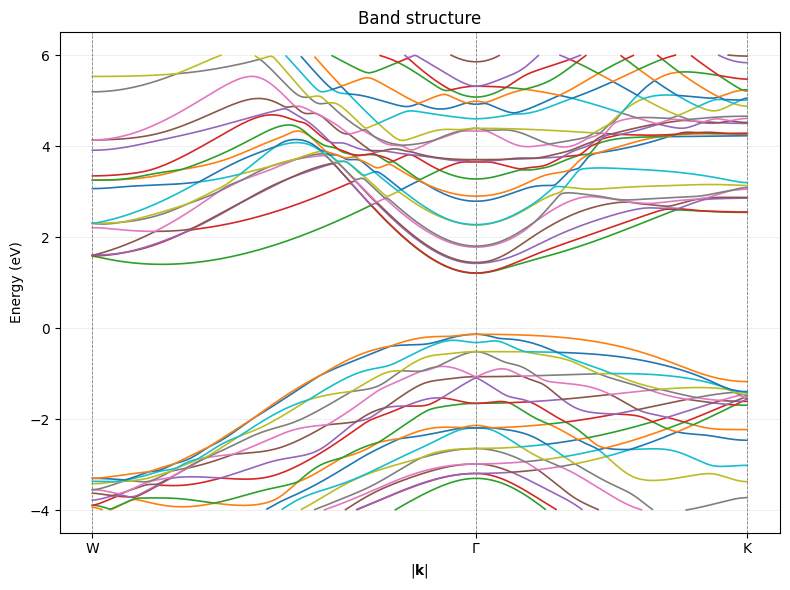

In [18]:
import numpy as np
import matplotlib.pyplot as plt


class BandStructurePlotter:

   
    def __init__(self, N: int, potential_profile: np.ndarray= None):
        self.N = N
        if potential_profile is None:
            self.V = np.asarray(potential_profile)
        
        self.k_path = None
        self.k_ticks = None      
        self.energies = None    

    # k space
    @staticmethod
    def _cumulative_distance(k_path):
        d = np.zeros(len(k_path))
        for i in range(1, len(k_path)):
            d[i] = d[i-1] + np.linalg.norm(k_path[i] - k_path[i-1])
        return d

    @staticmethod
    def _segment(a, b, n):
        """n points from a→b (excluding b)."""
        return np.linspace(a, b, n, endpoint=False)

    def build_k_path(self, corner_points, points_per_segment=200):
        """
        corner_points : list of 3-vectors (in Cartesian reciprocal space)
            e.g. [W, Γ, K, …].
        """
        k = []
        for p, q in zip(corner_points[:-1], corner_points[1:]):
            k.extend(self._segment(p, q, points_per_segment))
        k.append(corner_points[-1])          # include the last corner exactly
        self.k_path = np.array(k)
        self.k_ticks = {lbl: i*points_per_segment
                        for i, lbl in enumerate("".join((" " * (len(corner_points)-1))).split())}

    #eigen states
    def _compute_band_structure(self):
        assert self.k_path is not None, "call build_k_path() first"
        Nk = len(self.k_path)
        # get one eigen-spectrum just to know how many bands
        test_E = create_tight_binding(self.k_path[0], self.N)[0]
        Nb = test_E.size
        self.energies = np.empty((Nk, Nb))
        for i, kvec in enumerate(self.k_path):
            self.energies[i] = np.sort(create_tight_binding(kvec, self.N)[0].real)

    # plot
    def plot(self, energy_window=None, colour_cycle=None,
             k_labels=None, linewidth=1.2, figsize=(8, 6)):
        """
        energy_window : (Emin, Emax) tuple or None
            Energies outside are masked out (useful to hide surface bands).
        k_labels : dict {label: index} or None
            Override tick labels.  If None, W-Γ-K… order is auto-generated.
        """
        if self.energies is None:
            self._compute_band_structure()

        # x-axis
        k_x = self._cumulative_distance(self.k_path)

        # optional masking
        E = self.energies.copy()
        if energy_window is not None:
            Emin, Emax = energy_window
            E[(E < Emin) | (E > Emax)] = np.nan

        # plotting
        plt.figure(figsize=figsize)
        if colour_cycle:
            plt.gca().set_prop_cycle(color=colour_cycle)

        for band in range(E.shape[1]):
            plt.plot(k_x, E[:, band], lw=linewidth)

        # decorations
        plt.ylabel("Energy (eV)")
        plt.xlabel("$|\\mathbf{k}|$")
        plt.title("Band structure")
        plt.grid(True, ls="--", lw=0.4, alpha=0.5)

        # ticks at high-symmetry points
        if k_labels is None and self.k_ticks:
            k_labels = self.k_ticks
        if k_labels:
            tick_pos = [k_x[idx] for idx in k_labels.values()]
            for x in tick_pos:
                plt.axvline(x, color='grey', ls='--', lw=0.6)
            plt.xticks(tick_pos, list(k_labels.keys()))

        plt.tight_layout()
        plt.show()
# high symmetry points
a = 1.0
G  = np.array([0, 0])
K  = np.array([1/2, 1/2])
W  =np.array([-1,0])

# plot
N  = 4
plotter = BandStructurePlotter(N)
plotter.build_k_path([W, G, K], points_per_segment=200)

# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-4, 6),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})


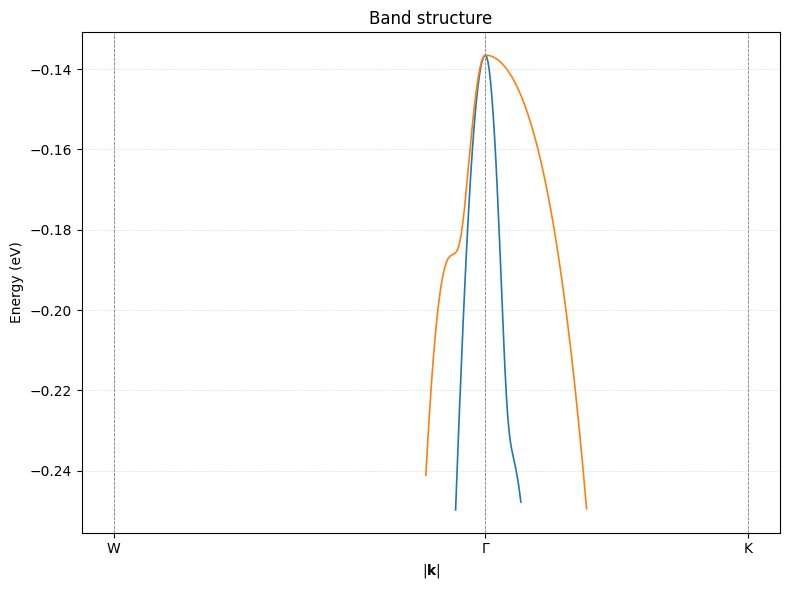

In [19]:
# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-.25, 0),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})

In [ ]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count

# create the k grid 
def make_mp_grid(Nk):
    """Return an (Nk3, 3) array of fractional k-vectors (0 … 1) in the 1st BZ."""
    shifts = np.linspace(0, 1, Nk, endpoint=True) + 0.5/Nk   
    klist  = np.array(list(product(shifts, repeat=2)))        

    return klist                                             

def analyzeRange(energies):
    largest_diff = [0,1,abs(energies[1] - energies[0])]
    for i,val in enumerate(energies[:-1]):
        diff = val - energies[i + 1]
        if abs(diff) > largest_diff[-1]:
            largest_diff[0] = i
            largest_diff[1] = i + 1
            largest_diff[-1] = abs(diff)
    
    return largest_diff[-1] + largest_diff[-1], 10
# helper method 
def frac_shift(k_frac, delta):
    return (k_frac + delta) % 1.0

#  effective-mass tensor around the CBM
def find_effective_mass(N, k_min_frac, Nk_coarse, band_idx,
                        resolution_factor=4, a=5.431e-10):


    delta_frac = 1.0 / (Nk_coarse * resolution_factor)        # we want a finer mesh size
    dk = (2*np.pi / a) * delta_frac                       


    k0 = np.asarray(k_min_frac, float)

    # get the good energy
    def E(k_frac):
        evs, _ = create_tight_binding(k_frac, N)
        energyTosend = evs[band_idx]
        print(energyTosend)
        
        return energyTosend
        

    #shift 
    ei = np.eye(2)

    # Hessian 
    H = np.zeros((2,2))
    for i in range(2):
        # second derivative along axis i
        kp = frac_shift(k0,  +delta_frac * ei[i])
        km = frac_shift(k0,  -delta_frac * ei[i])
        H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

        # mixed derivatives
        for j in range(i+1, 2):
            kpp = frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
            kmm = frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
            kpm = frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
            kmp = frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
            H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)

    # convert eV → J
    H_J = H * spc.e

    # m*  = hbar^2 *
    mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)           # kg
    mstar_me = mstar_SI / spc.m_e                         # in m_e

    prin_m, prin_axes = np.linalg.eigh(mstar_me)
    return mstar_me, prin_m, prin_axes
N =1
def eval_k(k_frac):
    """return the good eigenvalues"""
    eigvals, _ = create_tight_binding(k_frac, N)    
    vbm = eigvals[eigvals <=  0.0].max()     
    cbm = eigvals[eigvals >=  0.0].min()
    return vbm, cbm, eigvals
def scan_full_BZ(self,Nk=20, store_all=True, n_jobs=None, a=5.431e-10,
                 res_factor=4):
    """
    Nk       : number of k-points per reciprocal-lattice axis (Nk³ total)
    store_all: if True, return the entire E(k) array (size Nk³ × Nb)
    n_jobs   : cores to use; default = all available
    """
 
    klist = make_mp_grid(Nk)
    nbands = len(create_tight_binding(np.zeros(2), N)[0])   # quick probe
    
    dk = 1 / Nk
    # ----- parallel diagonalisation -----
    n_jobs = n_jobs or cpu_count()
    with Pool(processes=n_jobs) as pool:
        results = pool.map(eval_k, klist, chunksize=len(klist)//n_jobs)

    # collect extrema
    vbm_E, cbm_E = -np.inf, np.inf
    vbm_data = cbm_data = None
    if store_all:
        all_E = np.empty((len(klist), nbands))
      

    for idx, (v, c, eigs) in enumerate(results):
        if v > vbm_E:
            vbm_E      = v
            vbm_data   = (v, klist[idx], int(np.where(eigs==v)[0][0]))
        if c < cbm_E:
            
            cbm_E      = c
            cbm_data   = (c, klist[idx], int(np.where(eigs==c)[0][0]))
        if store_all:
            all_E[idx] = eigs

    
    
    
    Egap = cbm_E - vbm_E
    print(f"Fundamental gap = {Egap:.4f} eV")
    print("VBM : E = {:.4f} eV  at k_frac = {}".format(*vbm_data[:2]))
    print("CBM : E = {:.4f} eV  at k_frac = {}".format(*cbm_data[:2]))
    print("Direct gap" if np.allclose(vbm_data[1], cbm_data[1]) else "Indirect gap")
    mstar, prin_m, prin_ax = find_effective_mass(N, cbm_data[1], Nk,
                                                 cbm_data[2],
                                                 resolution_factor=res_factor,
                                                 a=a)
    print("\nEffective-mass tensor at CBM:\n", mstar)
    print("Principal masses:\n", prin_m)

    if store_all:
        return (Egap, vbm_data, cbm_data,
                klist, all_E,
                mstar, prin_m, prin_ax)
    return Egap, vbm_data, cbm_data, mstar, prin_m, prin_ax


Egap, vbm, cbm, klist, allE, M, m_prin, axes = scan_full_BZ(1, Nk=41, store_all=True, res_factor=6)

print("\ndelta-valley:  m_l = {:.3f}  m_t = {:.3f}  (in me)".format(m_prin.max(), m_prin.min()))



Fundamental gap = 2.4295 eV
VBM : E = -0.6585 eV  at k_frac = [0.01219512 0.01219512]
CBM : E = 1.7710 eV  at k_frac = [1.01219512 1.01219512]
Indirect gap
1.7737637483902622
1.7690067893400045
1.770990049075661
1.7765104213100749
1.7670097174812753
1.7717998102643062
1.771799810264309
1.7737637483902693
1.7690067893400132
1.770990049075661

Effective-mass tensor at CBM:
 [[0.21334806 0.00536324]
 [0.00536324 0.21334806]]
Principal masses:
 [0.20798482 0.21871131]

delta-valley:  m_l = 0.219  m_t = 0.208  (in me)


In [ ]:
import numpy as np
from math import factorial, sqrt
import scipy.conftest
import scipy.constants
from scipy.special import sph_harm, genlaguerre
import fipy as fp

def _Rnl_array(n, l, r, a0=1.0):
    """Radial wave function"""
    pref = sqrt((2.0 / (n * a0))**3 * factorial(n - l - 1) /
                (2.0 * n * factorial(n + l)))
    rho = 2.0 * r / (n * a0)
    L = genlaguerre(n - l - 1, 2 * l + 1)      
    return pref * np.exp(-rho / 2.0) * rho**l * L(rho)

def _Ylm_array(l, m, dx, dy, dz, real=False):
    """Spherical harmonics Y_l^m"""
    r     = np.sqrt(dx*dx + dy*dy + dz*dz)
    theta = np.arccos(np.where(r == 0.0, 0.0, dz / r))
    phi   = np.arctan2(dy, dx)
    Y = sph_harm(m, l, phi, theta)      

    if real:
        if m > 0:
            Y = np.sqrt(2.) * (-1)**m * Y.real
        elif m < 0:
            Y = np.sqrt(2.) * (-1)**m * Y.imag
    return Y

def line_wavefunction(unitCell, eigv,
                      x0=0.25, y0=0.50,   
                      return_charge=True):
    Nz = unitCell.Nz
    z_coord = np.linspace(0.0, unitCell.N, Nz)   
    psi = np.zeros(Nz, dtype=np.complex128)

    orbital_qnums = {
        's' :(3,0, 0), 'px':(3,1,+1), 'py':(3,1,-1), 'pz':(3,1, 0),
        'dxy':(3,2,+2), 'dyz':(3,2,-1), 'dzx':(3,2,+1),
        'dx2y2':(3,2,-2), 'dz2':(3,2, 0), 's*':(4,0, 0)
    }
    orbitals = ['s','px','py','pz','dxy','dyz','dzx','dx2y2','dz2','s*']

    for atom_idx, atom in enumerate(unitCell.ATOM_POSITIONS):
        dx = x0 - atom.x
        dy = y0 - atom.y
        dz = z_coord - atom.z          
        r  = np.sqrt(dx*dx + dy*dy + dz*dz)

        for orb_idx, name in enumerate(orbitals):
            n, l, m = orbital_qnums[name]
            coeff   = eigv[atom_idx*10 + orb_idx]

            radial  = _Rnl_array(n, l, r)
            ang     = _Ylm_array(l, m,
                                 np.broadcast_to(dx, Nz),
                                 np.broadcast_to(dy, Nz),
                                 dz, real=False)

            psi += coeff * radial * ang

    if return_charge:
        q = -scipy.constants.elementary_charge
        return z_coord, q * np.abs(psi)**2
    else:
        return z_coord, psi

def fillInGrid_vectorised(unitCell, eigv):
    """Return complex wave‑function values on the whole unit‑cell grid."""
    Nx, Ny, Nz = unitCell.Nx, unitCell.Ny, unitCell.Nz

    gx, gy, gz = np.meshgrid(np.arange(Nx),
                             np.arange(Ny),
                             np.arange(Nz),
                             indexing="ij")

    arrx = gx * 0.25 / (Nx - 1) + 0.25
    arry = gy * 0.25 / (Ny - 1) + 0.25
    rot  = UnitCell.createRotationMatrix(-np.pi/4 - np.pi/2)
    x = rot[0,0] * arrx + rot[0,1] * arry
    y = rot[1,0] * arrx + rot[1,1] * arry
    z = gz * unitCell.N / (Nz - 1)


    psi = np.zeros_like(x, dtype=np.complex128)

 
    orbital_qnums = {
        's'     :(3,0, 0),  'px'   :(3,1,+1), 'py'   :(3,1,-1), 'pz'   :(3,1, 0),
        'dxy'   :(3,2,+2),  'dyz'  :(3,2,-1), 'dzx'  :(3,2,+1),
        'dx2y2' :(3,2,-2),  'dz2'  :(3,2, 0), 's*'   :(4,0, 0)
    }
    orbitals = ['s','px','py','pz','dxy','dyz','dzx','dx2y2','dz2','s*']

    for atom_index, atom in enumerate(unitCell.ATOM_POSITIONS):
        Ra = np.asarray([atom.x, atom.y, atom.z])
        dx = x - Ra[0]
        dy = y - Ra[1]
        dz = z - Ra[2]
        r  = np.sqrt(dx*dx + dy*dy + dz*dz) 

        for orb_index, name in enumerate(orbitals):
            n, l, m = orbital_qnums[name]
            coeff   = eigv[atom_index*10 + orb_index]

            radial  = _Rnl_array(n, l, r)
            ang     = _Ylm_array(l, m, dx, dy, dz, real=False) 

            psi += coeff * radial * ang

    return psi   
def wavefunction_grid(unitCell, eigv):
    return fillInGrid_vectorised(unitCell, eigv)  

def charge_density_grid(unitCell, eigv):
    psi = wavefunction_grid(unitCell, eigv)
    q   = -scipy.constants.elementary_charge 
    rho = q * np.abs(psi)**2  
    return rho

def modifyForVoltage(rho):
    rho_x = np.concatenate((rho[::-1, :, :], rho), axis=0)      
    rho_xy = np.concatenate((rho_x[:, ::-1, :], rho_x), axis=1)   
    rho_sym = 0.5 * (rho_xy + rho_xy.transpose(1, 0, 2))
    return rho_sym
    

def solvePoisson(rho_data, Vg):
    Nx,Ny,Nz = rho_data.shape
    dx,dy,dz = 1 / (Nx - 1), 1 / (Ny - 1), 1 / (Nz - 1)
    mesh = fp.meshes.periodicGrid3D.\
       PeriodicGrid3DLeftRightFrontBack(
           dx=dx, dy=dy, dz=dz, nx=Nx, ny=Ny, nz=Nz)
    phi  = fp.CellVariable(mesh=mesh, name="phi")          # potential
    rho  = fp.CellVariable(mesh=mesh,                     # charge density
                        value=rho_data.ravel())        # ← your data
    eps0 = 8.854e-12    
    eq = fp.DiffusionTerm(coeff=1.0) == -rho/eps0

    # Dirichlet on bottom (z=0) and top (z=Lz)
    phi.constrain(Vg, mesh.facesBottom)                  # V = 0  bottom
    phi.constrain(Vg, mesh.facesTop)                     # V = 0.1 top

    eq.solve(var=phi, solver=fp.LinearLUSolver())

    return np.asarray(phi.value).reshape(rho_data.shape)

def doEverythingOnce():
    unitCell = UnitCell(1)
    unitCell.setGrid(10,10,20)
    


/tmp/ipykernel_1058710/4048516249.py:21: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y = sph_harm(m, l, phi, theta)


In [ ]:
# broken 

def getTheDOS(E, N, sigma):
    def gaussian(En):
        return 1 / np.sqrt(2 * np.pi * sigma) * np.exp(-(E - En)**2 / (2 * sigma))
    D = 0
    for kx in np.linspace(-1,1,50):
        kx = 2 *np.pi / a * kx
        for ky in np.linspace(-1,1,50):
                energies = create_tight_binding(np.array([kx, ky, 0]), N, potentialProfile)[0]
                for en in energies:
                    D += gaussian(en)
            
    
    return D
        

def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 4 * N * 8

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

    

In [ ]:
# test code for DOS
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as spc

hbar = 1       
m    = 1
q    = 1
L    = 1
Ec = 1 

Lz   = 20         

Nk = 40000

k = np.linspace(-np.pi / L, np.pi / L, Nk)
Ek = hbar**2 * k**2 / (2 * m) + Ec          # dispersion

sigma = .001
E = np.linspace(Ek.min(), Ek.max(), 1000)    # energy axis
dos = np.sum(np.exp(-(E[:, None] - Ek[None, :])**2 / (2 * sigma**2)), axis=1)
dos /= np.sqrt(2 * np.pi) * sigma      # normalize Gaussians
realdos = m * L / hbar / np.pi * np.sqrt((1 / (2 * m * (E - Ec))))




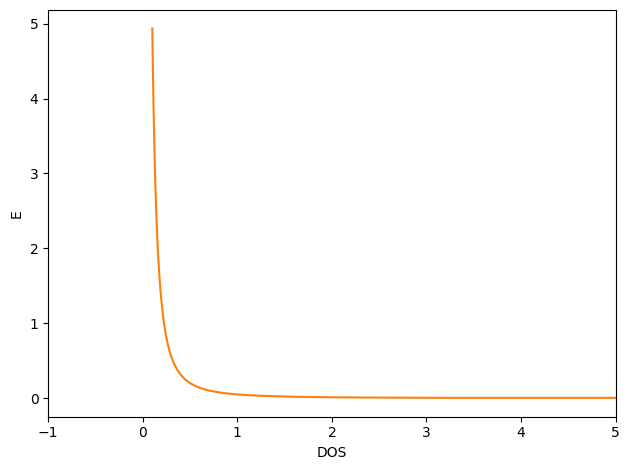

In [ ]:
#print(dos)
plt.plot(dos, (E - Ec)/q)


plt.plot(realdos, (E - Ec)/q)
plt.xlabel('DOS')
plt.xlim((-1,5))
plt.ylabel('E')
plt.tight_layout()
plt.show()

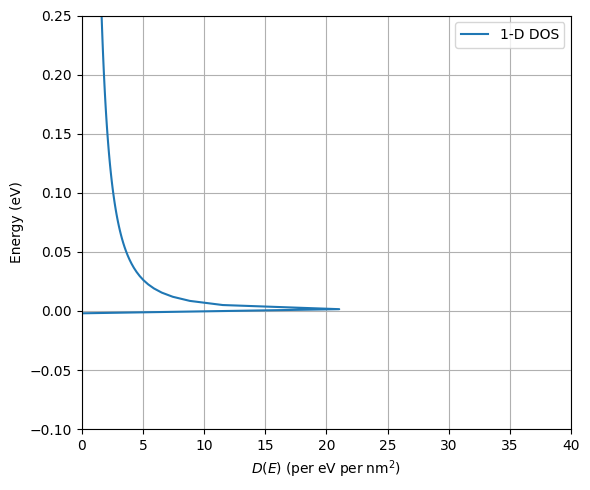

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- physical constants (SI; energies stay in eV) ---
hbar = 1.055e-34       # J·s
m    = 9.110e-31       # kg
q    = 1.602e-19       # C   (eV → J conversion factor)
L    = 1e-9            # 1 nm in m


Lz   = 20e-9           # m   (set 5e‑9 for case (a))

# sub‑band spacing
E0 = (hbar**2 * np.pi**2) / (2 * q * m * Lz**2)   # eV

# energy axis (eV)
E = np.linspace(-0.1, 0.25, 101)

# Heaviside steps θ(E) and θ(E – E_p)
theta_E  = (E > 0).astype(float)                  # θ(E)
D2       = np.zeros_like(E)                      

for p in range(1, 26):                            # p = 1 … 25
    EE       = E - (p * p * E0)
    theta_EE = (EE > 0).astype(float)             # θ(E – E_p)

    D1 = np.zeros_like(E)
    mask = E > 0                     
    D1[mask] = (L * q * m /
                (np.pi * hbar) *
                (2 * m * q * E[mask])**(-0.5))

    D2 += (L**2 * q * m * theta_EE) / (2 * np.pi * hbar**2)

    if p == 25:                                   # save last‑pass 3‑D term
        D3 = (L**3 * q * m * theta_E /
               (2 * np.pi**2 * hbar**3) *
               np.sqrt(2 * m * q * np.maximum(E, 0)))

# --- plotting (matches MATLAB order: x = DOS, y = E) ---
plt.figure(figsize=(6, 5))
plt.plot(D1,              E, label="1‑D DOS", linewidth=1.5)
#plt.plot(D3 * Lz / L,     E, label="3‑D DOS × (Lz/L)", linewidth=1.5)

plt.xlim(0, 40)           # part (b) limits; use (0,10) for part (a)
plt.ylim(-0.1, 0.25)
plt.xlabel(r"$D(E)\;(\mathrm{per\;eV\;per\;nm^2})$")
plt.ylabel("Energy (eV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:



def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 1

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F



In [ ]:
 
energies = np.linspace(-1,1, 501)
def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 1

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

### old sp3

In [ ]:

def create_tight_binding(k, N, potentialProfile):
    kx,ky,kz = k
    unitCell = UnitCellGeneration(N)
    unitNeighbors = unitCell.neighborTable()
    numSilicon = len(unitNeighbors.keys())
    size = numSilicon* 4 # sp3
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
  
    orbitals = ['s', 'px', 'py', 'pz']
    
    # old code with no dangling bonds 
    """for atom_index in range(numSilicon):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 4 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]"""

            
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*4:(atom_idx+1)*4, atom_idx*4:(atom_idx+1)*4] = onsiteMatrix
    
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * 4 + orbitalIndex
            
            effectiveZinPotential = int(atom.z)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * 4 + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                        
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, eigv, A